In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [7]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

### 1-1. 데이터 크기
훈련 데이터의 크기는 15035개이며 21개의 요소를 가지고 있음. 
테스트 데이터의 크기는 6468개이며 20개의 요소를 가지고 있음(훈련데이터는 price를 가지고 있지 않음)

In [8]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


## 1-2. 데이터 요소 살펴보기

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [9]:
train.keys()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 2. 간단한 데이터 전처리
1. Date를 년-월만 나오도록 처리.
2. 훈련데이터의 price, id 열 삭제.
3. 테스트 데이터의 id열 삭제

In [10]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
del train['id']

train.head()



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
y = train['price']
del test['id']
print(train.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [12]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 3. 결측치 확인 
1. 전체 데이터를 보기 위해 훈련데이터와 테스트 데이터를 합치기.
2. msno.matrix를 통한 시각화 및 결측치 isnull을 활용 count하여 확인하기.

21503


<AxesSubplot:>

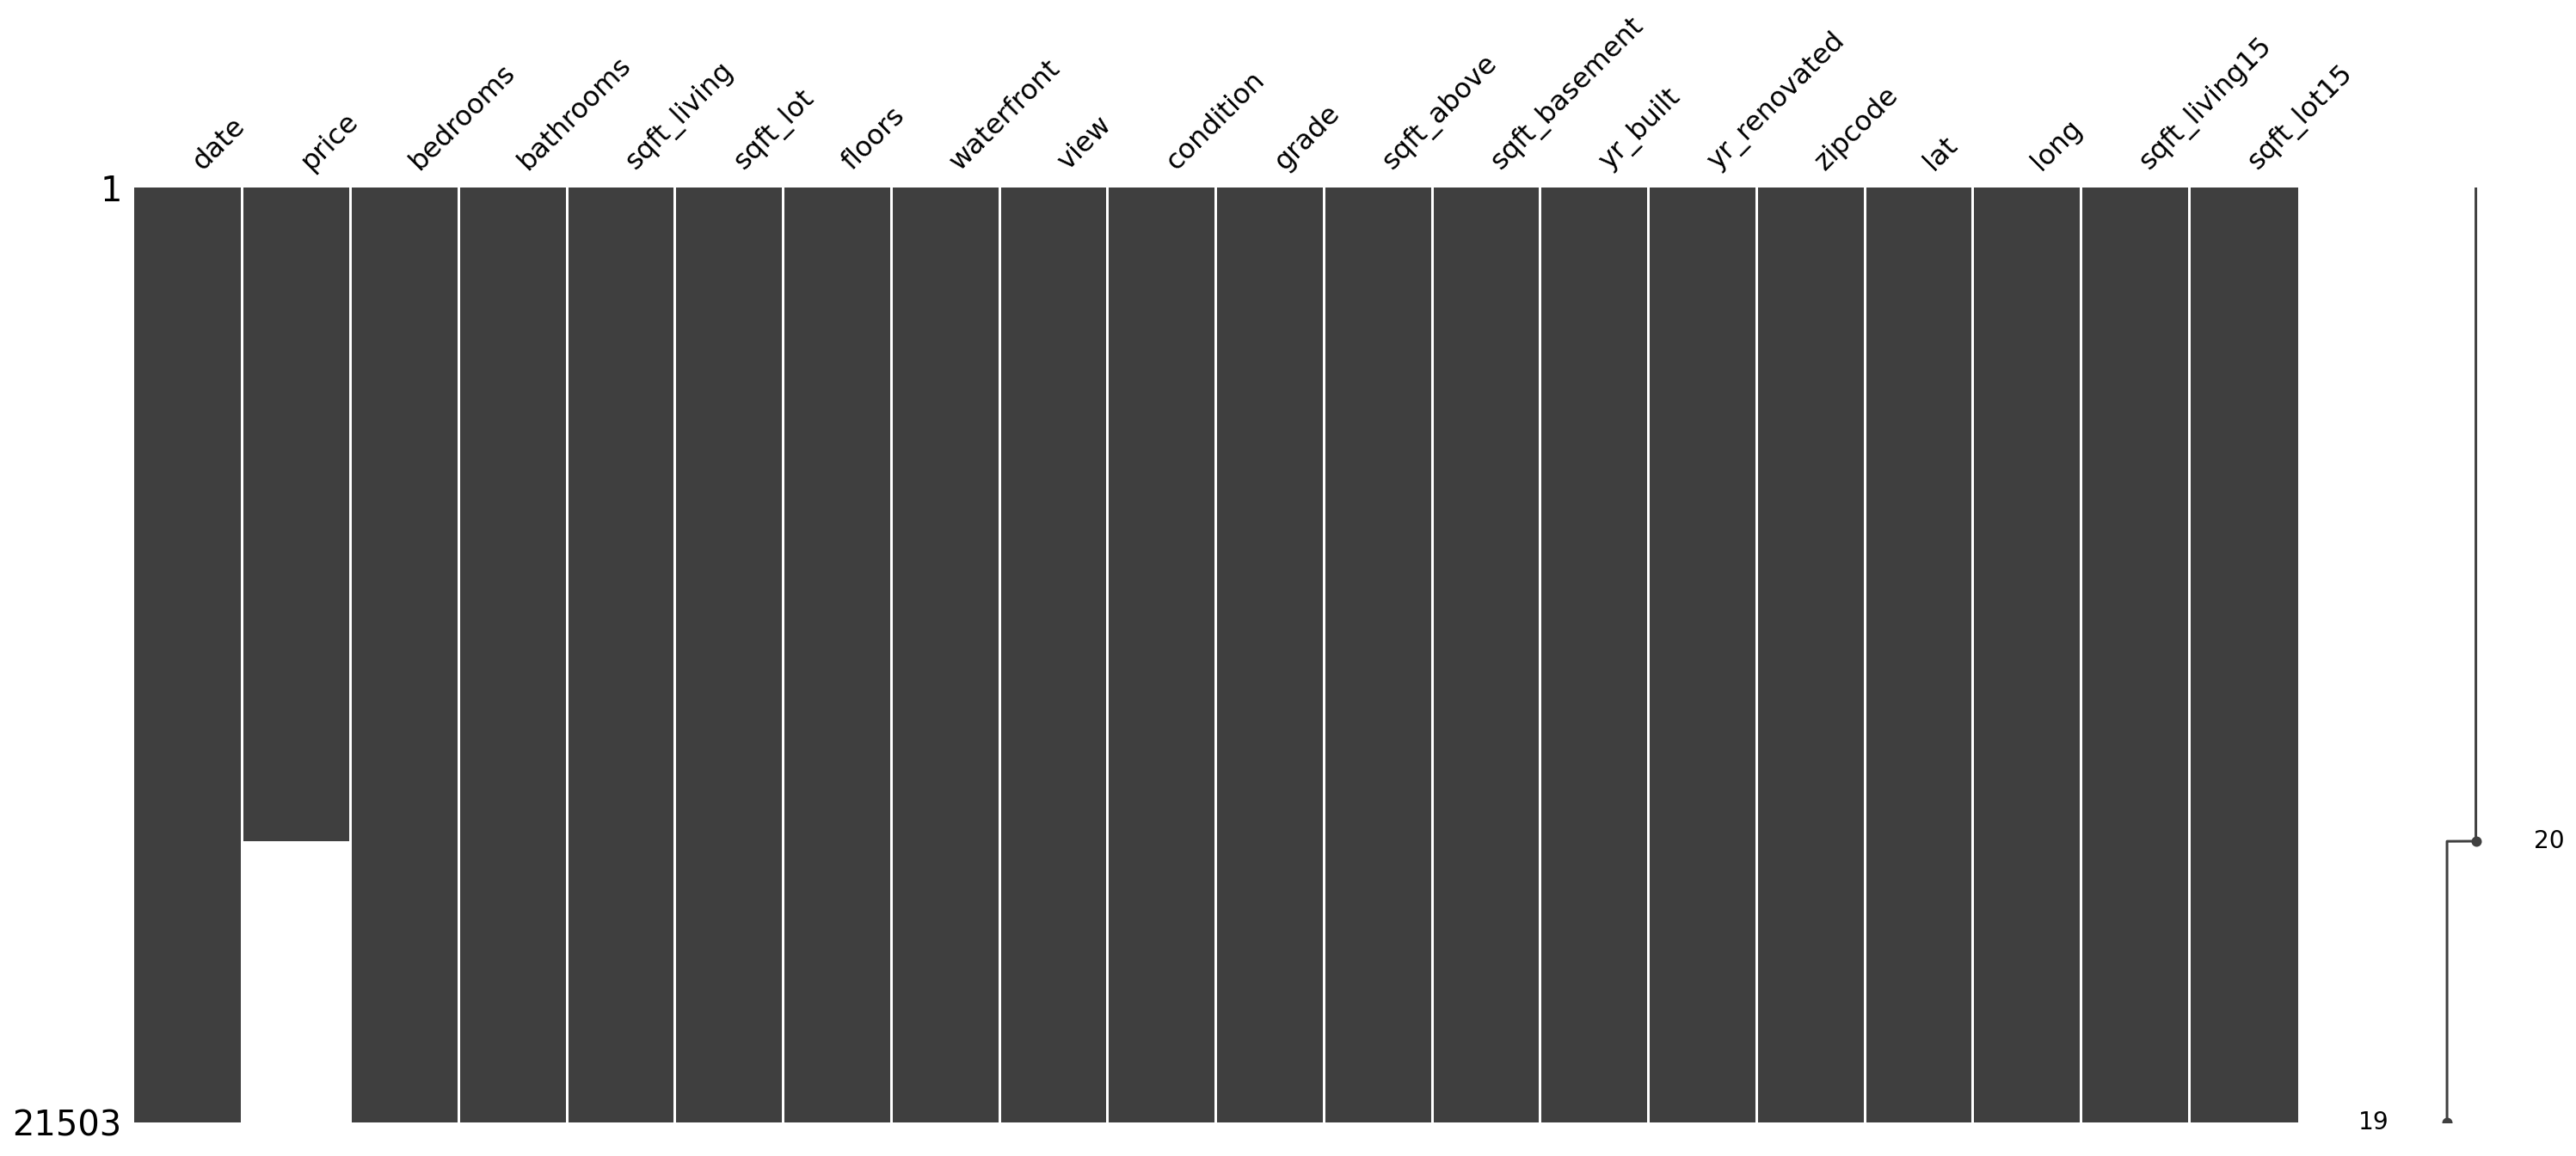

In [13]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))
msno.matrix(data)


In [14]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


* train 데이터와 test 데이터를 합치고난 후 결측치를 판단하였습니다. 이 과정에서 train 데이터에는 price 열이 있지만 test 데이터에는 price 열이 없기 때문에 price에 대하여 test 데이터의 수많큼(6468) 없다는 것이 나왔습니다. 따라서 결측치가 없는 것으로 판단됩니다. 

## 4. 훈련 데이터 시각화
* 훈련 데이터의 요소별 분포 확인을 위해 kdeplot을 통해 확인했습니다.

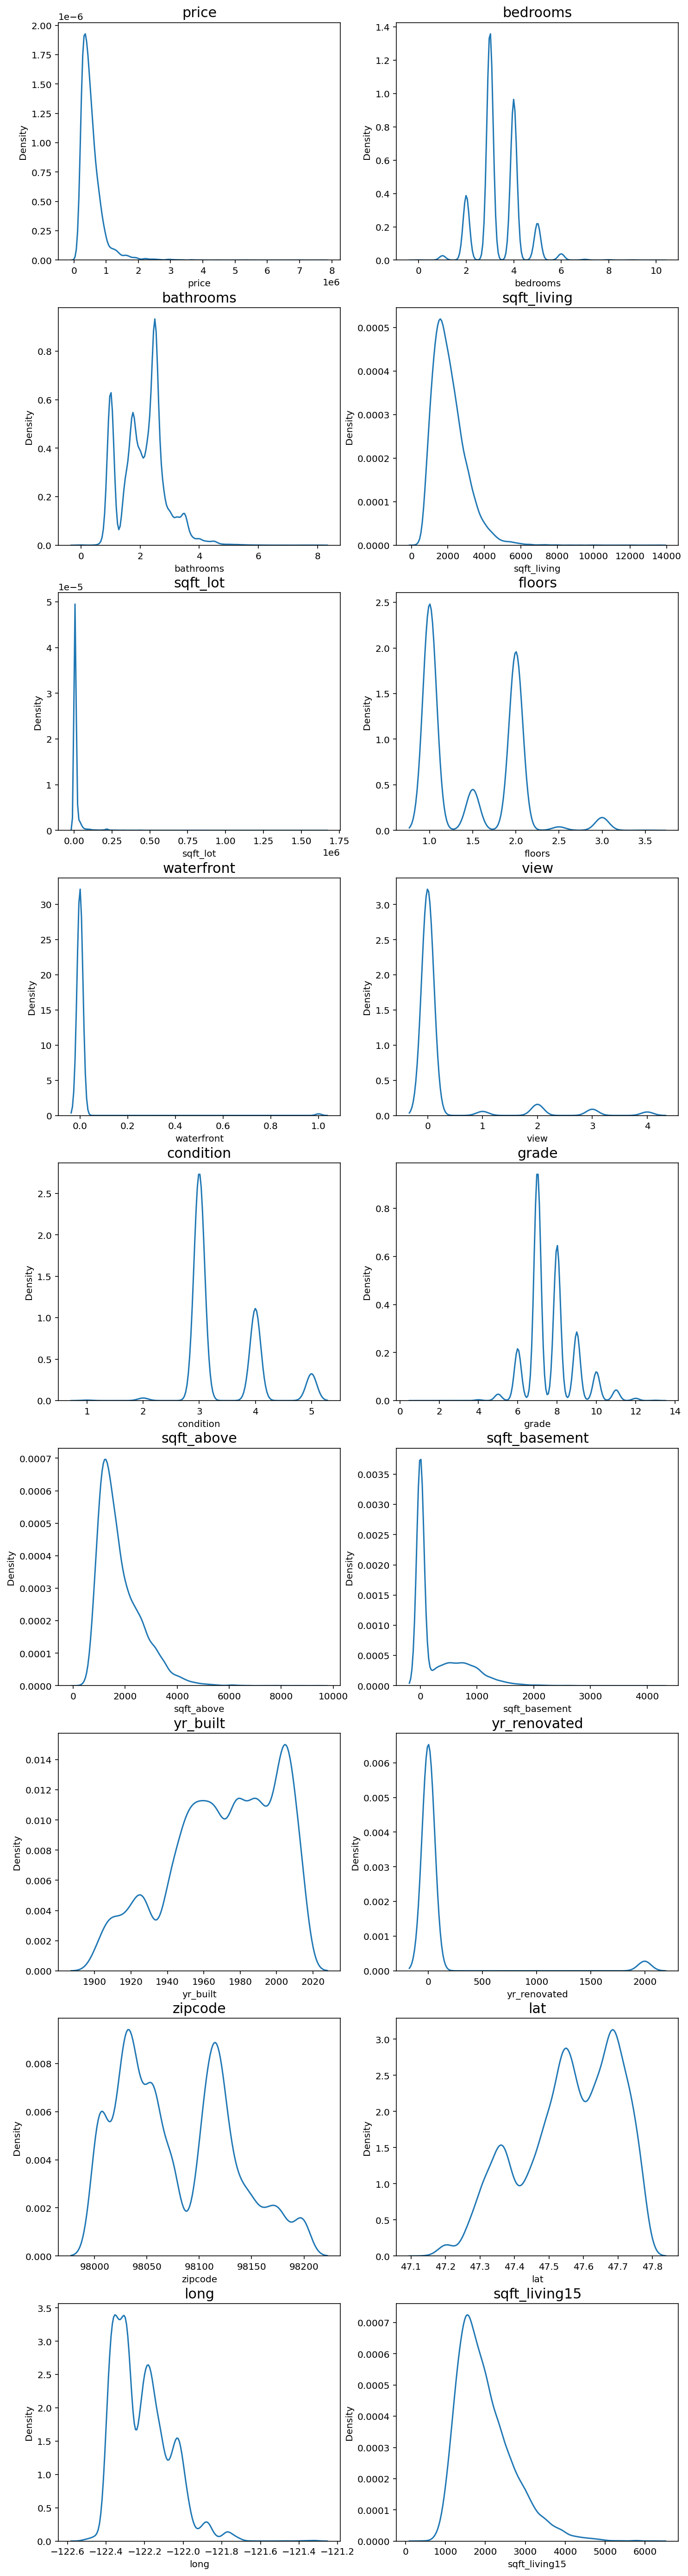

In [15]:

fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

* bedroom, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우쳐있음.

* 이후 데이터 전처리를 통해 정규화 시킬 예정.

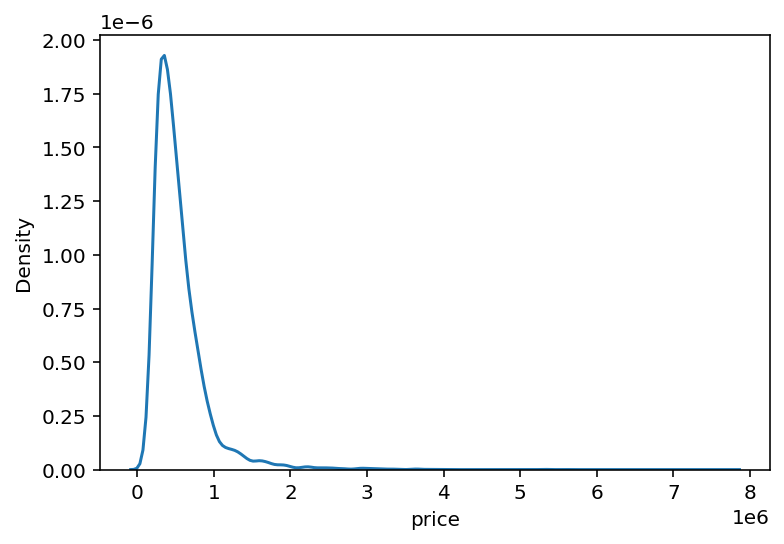

In [16]:
sns.kdeplot(y)
plt.show()

* price 또한 한쪽으로 치우쳐져있음.
* 이후 데이터 전처리를 통해 정규화 시킬 예정.

## 4. Price에 대한 각 요소들 관계 시각화
* Price에 대하여 각 요소들의 상관관계를 파악하기위해 시각화를 했습니다.
* 요소들 중에 범주형에 해당하는 것은 date, bedrooms ,bathrooms, floors, waterfront, view, condition, grade, yr_built,yr_renovated에 해당하는 것으로 판단됩니다.
* 범주형에 해당하는것은 boxplot을 통해 시각화해봤습니다.

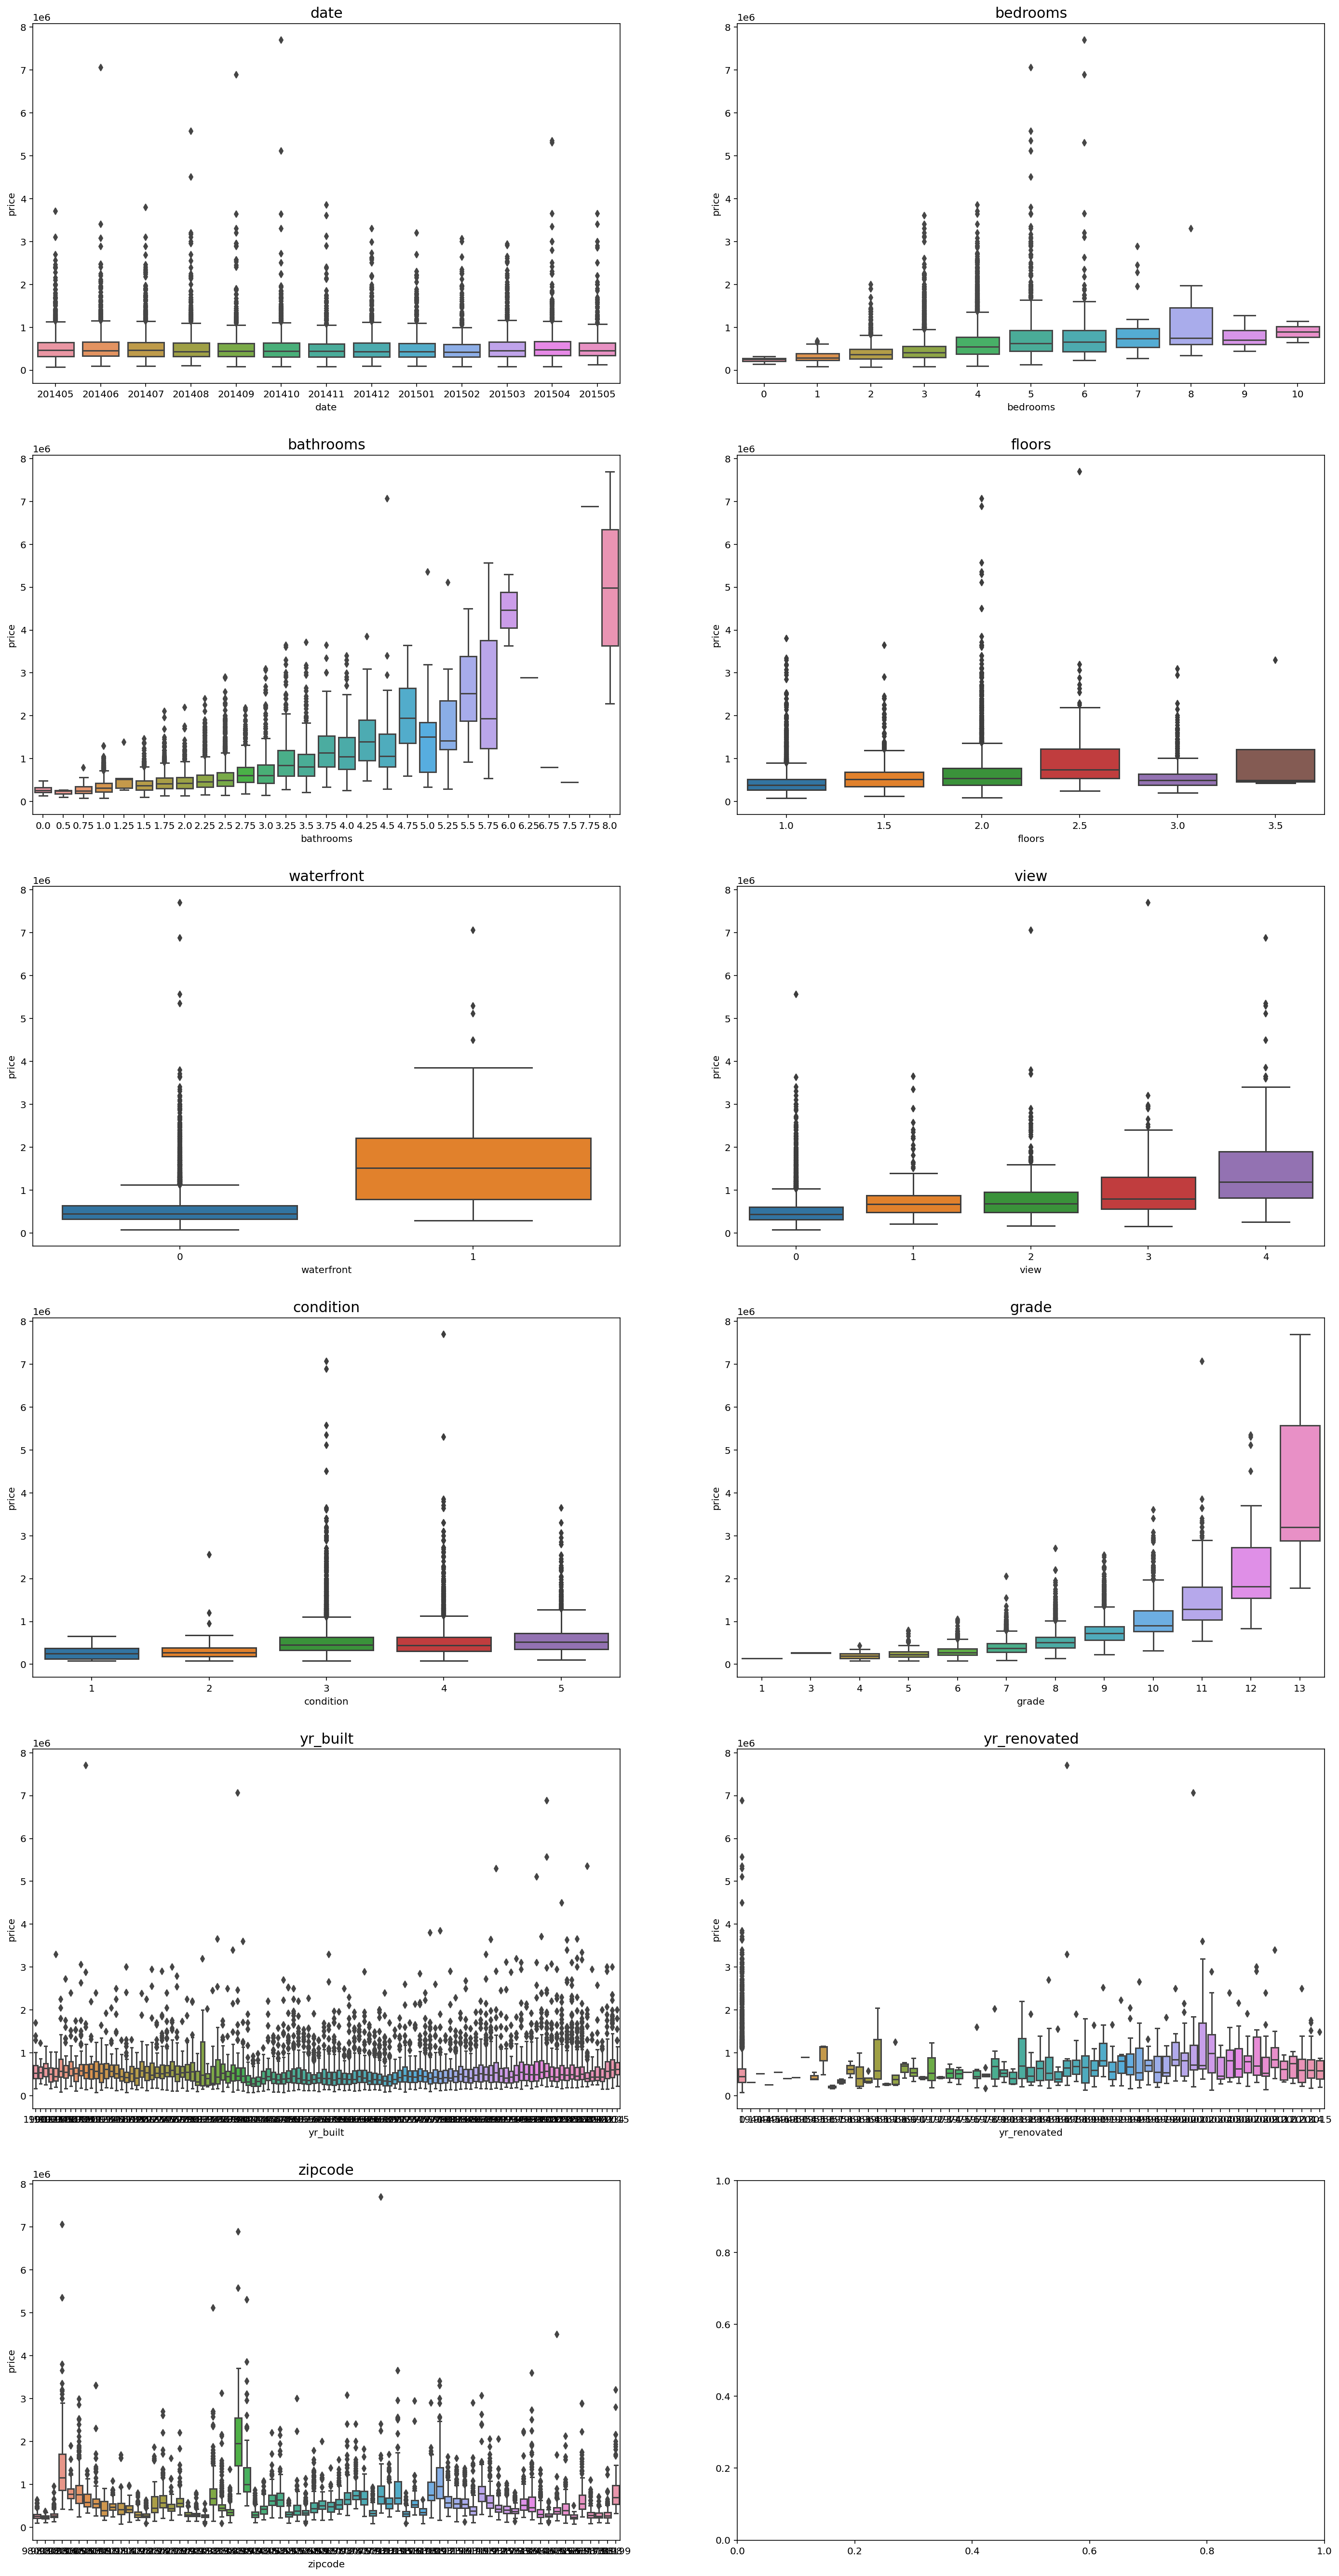

In [17]:
skew_columns = ['date' ,'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade','yr_built','yr_renovated','zipcode']
    
fig, ax = plt.subplots(6, 2, figsize=(24, 48))

count = 0
for row in range(6):
    for col in range(2):
        if count == 11:
            break
        sns.boxplot(x=skew_columns[count], y="price", data=train,ax=ax[row][col])
      
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1## 4. 전체 데이터 시각화


* 시각화로 봤을때 price와 양의 상관관계가보이는 요소는 bedrooms, bathrooms, waterfront(존재),view, condition, grade로 보입니다. 나머지는 상관관계가 눈으로봤을 때는 없어보입니다. 
* 수치형 데이터에 대해서는 scatter plot과 line plot을 함께 볼수 있는 regplot으로 그려봤습니다.

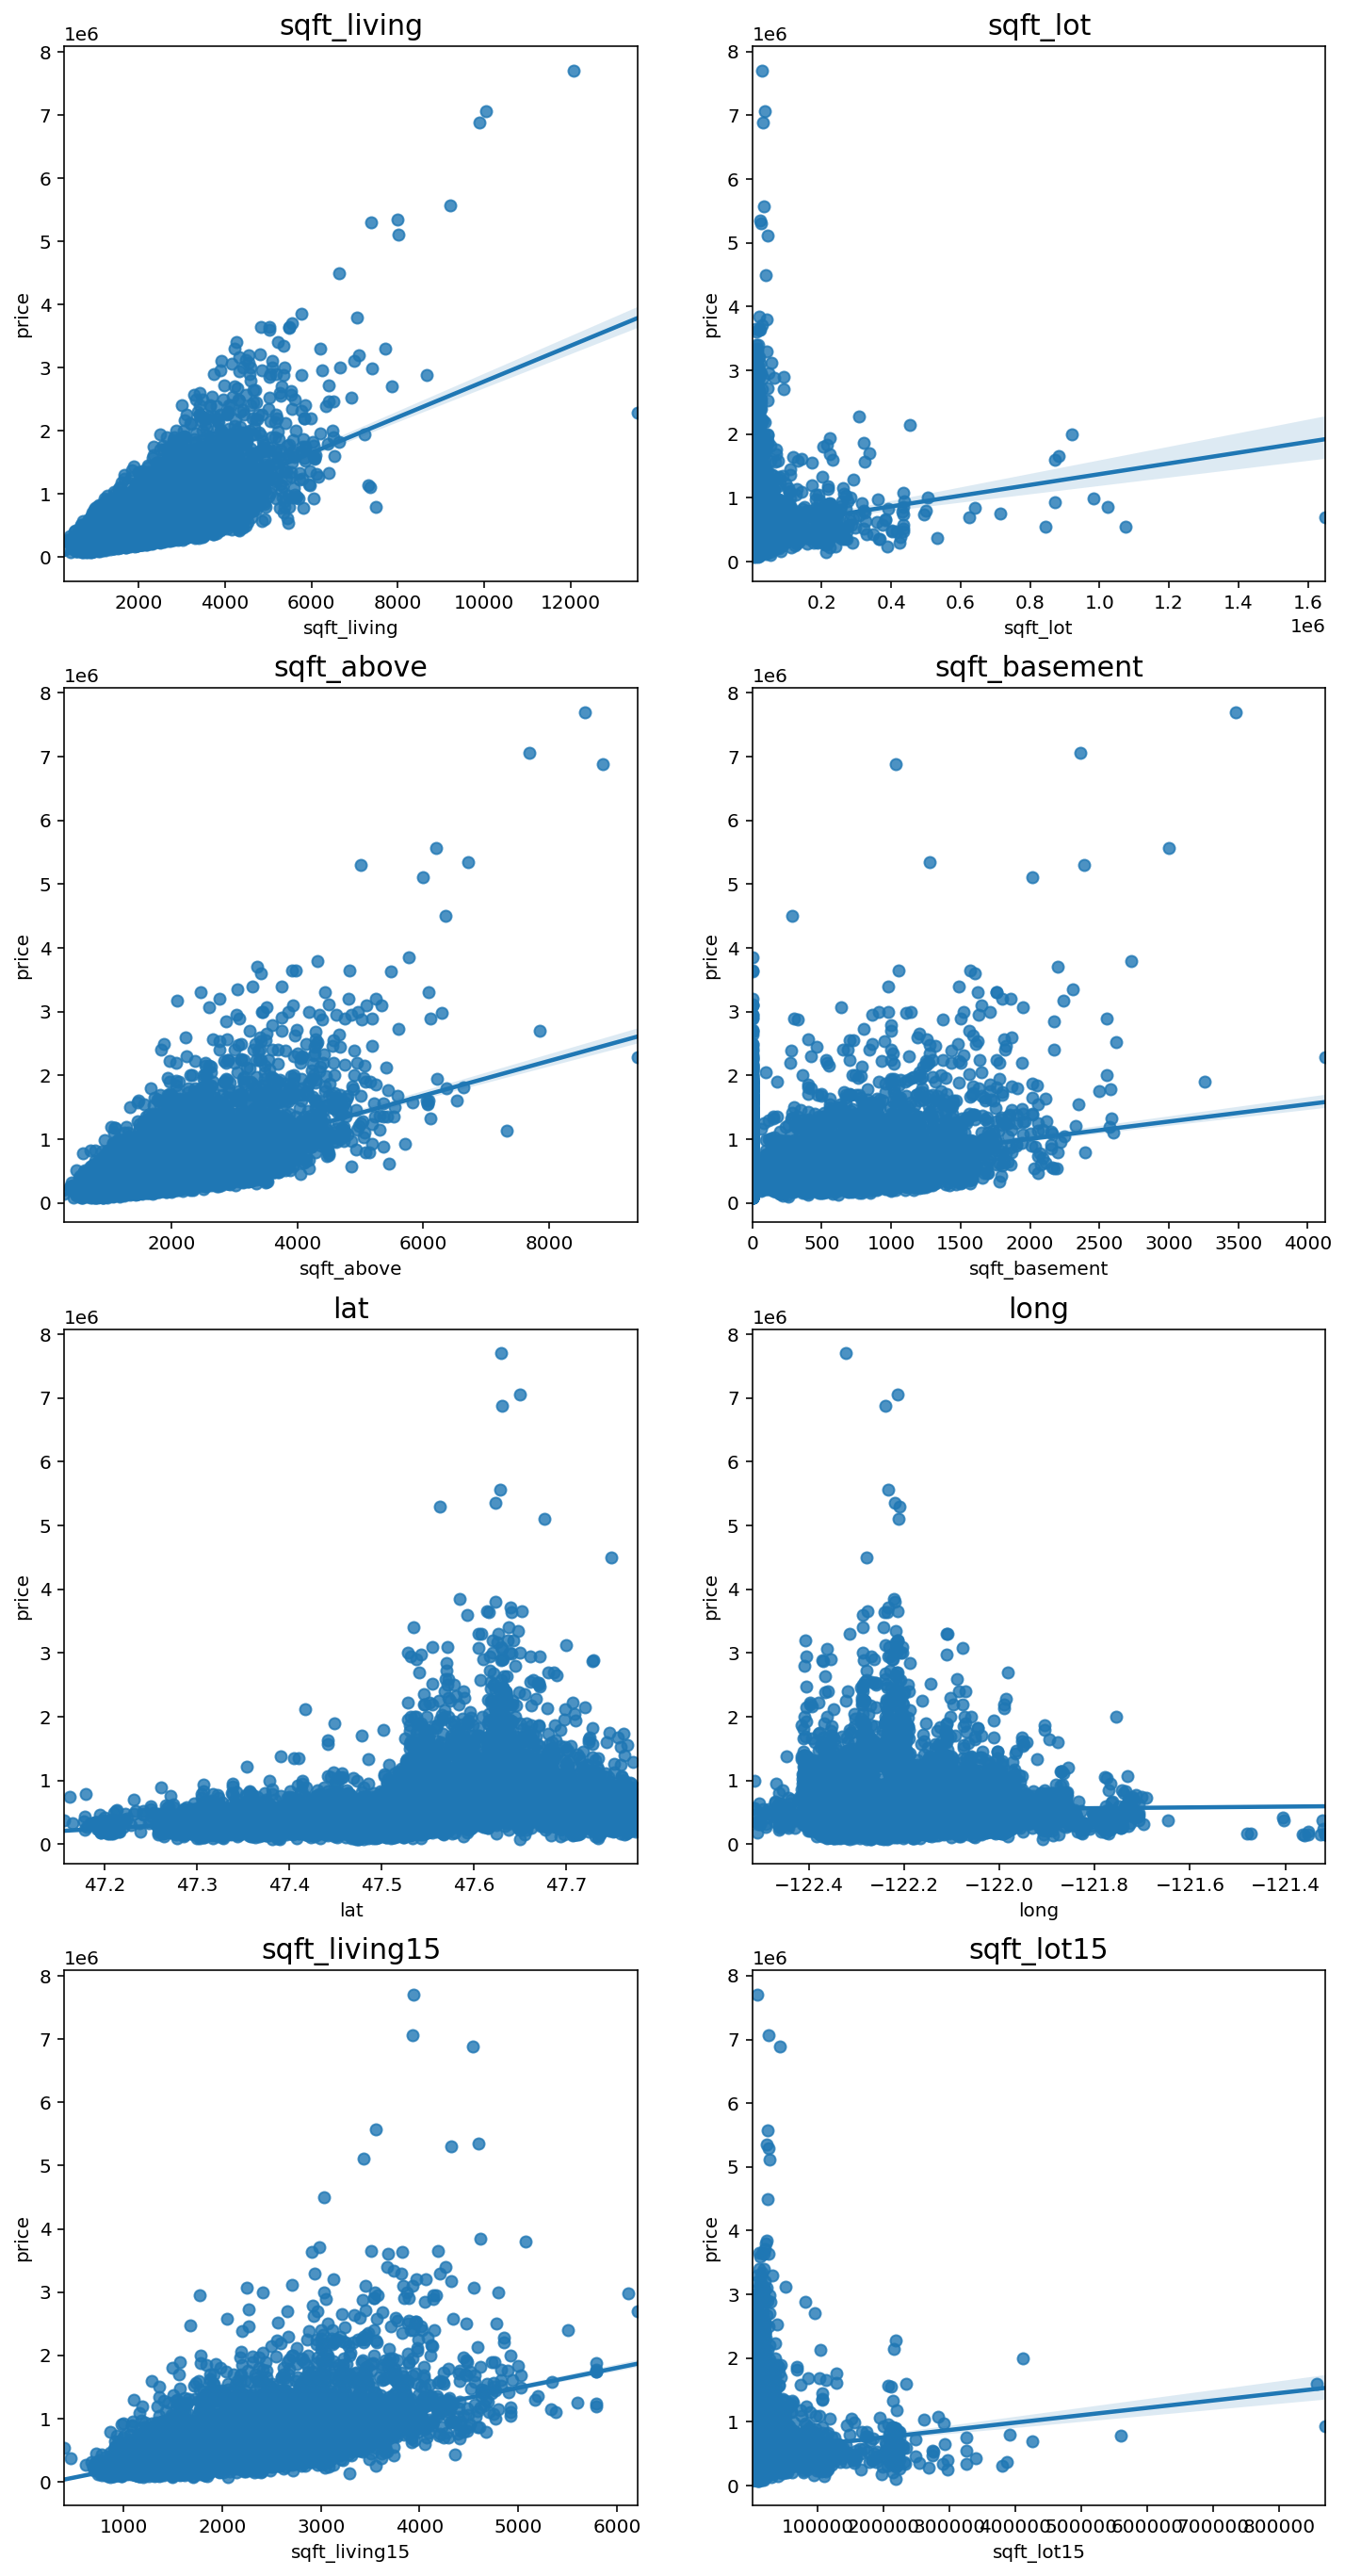

In [18]:
skew_columns = ['sqft_living' ,'sqft_lot', 'sqft_above', 'sqft_basement', 'lat','long','sqft_living15','sqft_lot15']
    
fig, ax = plt.subplots(4,2, figsize=(12, 24))

count = 0
for row in range(5):
    for col in range(2):
        if count == 8:
            break
        sns.regplot(x=skew_columns[count], y="price", data=train,ax=ax[row][col])
      
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1## 4. 전체 데이터 시각화



* 그래프로만 봤을때 price와 상관관계를 잘 파악할 수 없었습니다.
* 그래프로는 정확히 알 수 없어 상관관계를 수치화 하여 가장 영향을 많이 주는 요소 10개를 뽑아봤습니다.
* pandas의 corr 메소드를 피어스만 순위 상관관계(범주형 데이터도 있기 때문)로 계산하고 가장 큰값 부터 정렬하여 정리하겠습니다.

## - 상관계수를 활용한 연관성 순위 확인

In [19]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 

cor_data = cor_abs.nlargest(n=11, columns='price')['price']
print(cor_data)

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
view             0.291720
sqft_basement    0.245304
Name: price, dtype: float64


* 가격에 가장 영항을 많이 주는 요소는, grade, sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement 순이었습니다. 

## 5. 데이터 전처리

### 5-1 정규화
* kde 분포를 봤을 때 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15'가 한쪽으로 치우쳐져 있어 log 함수를 통해 정규화 하겠습니다.

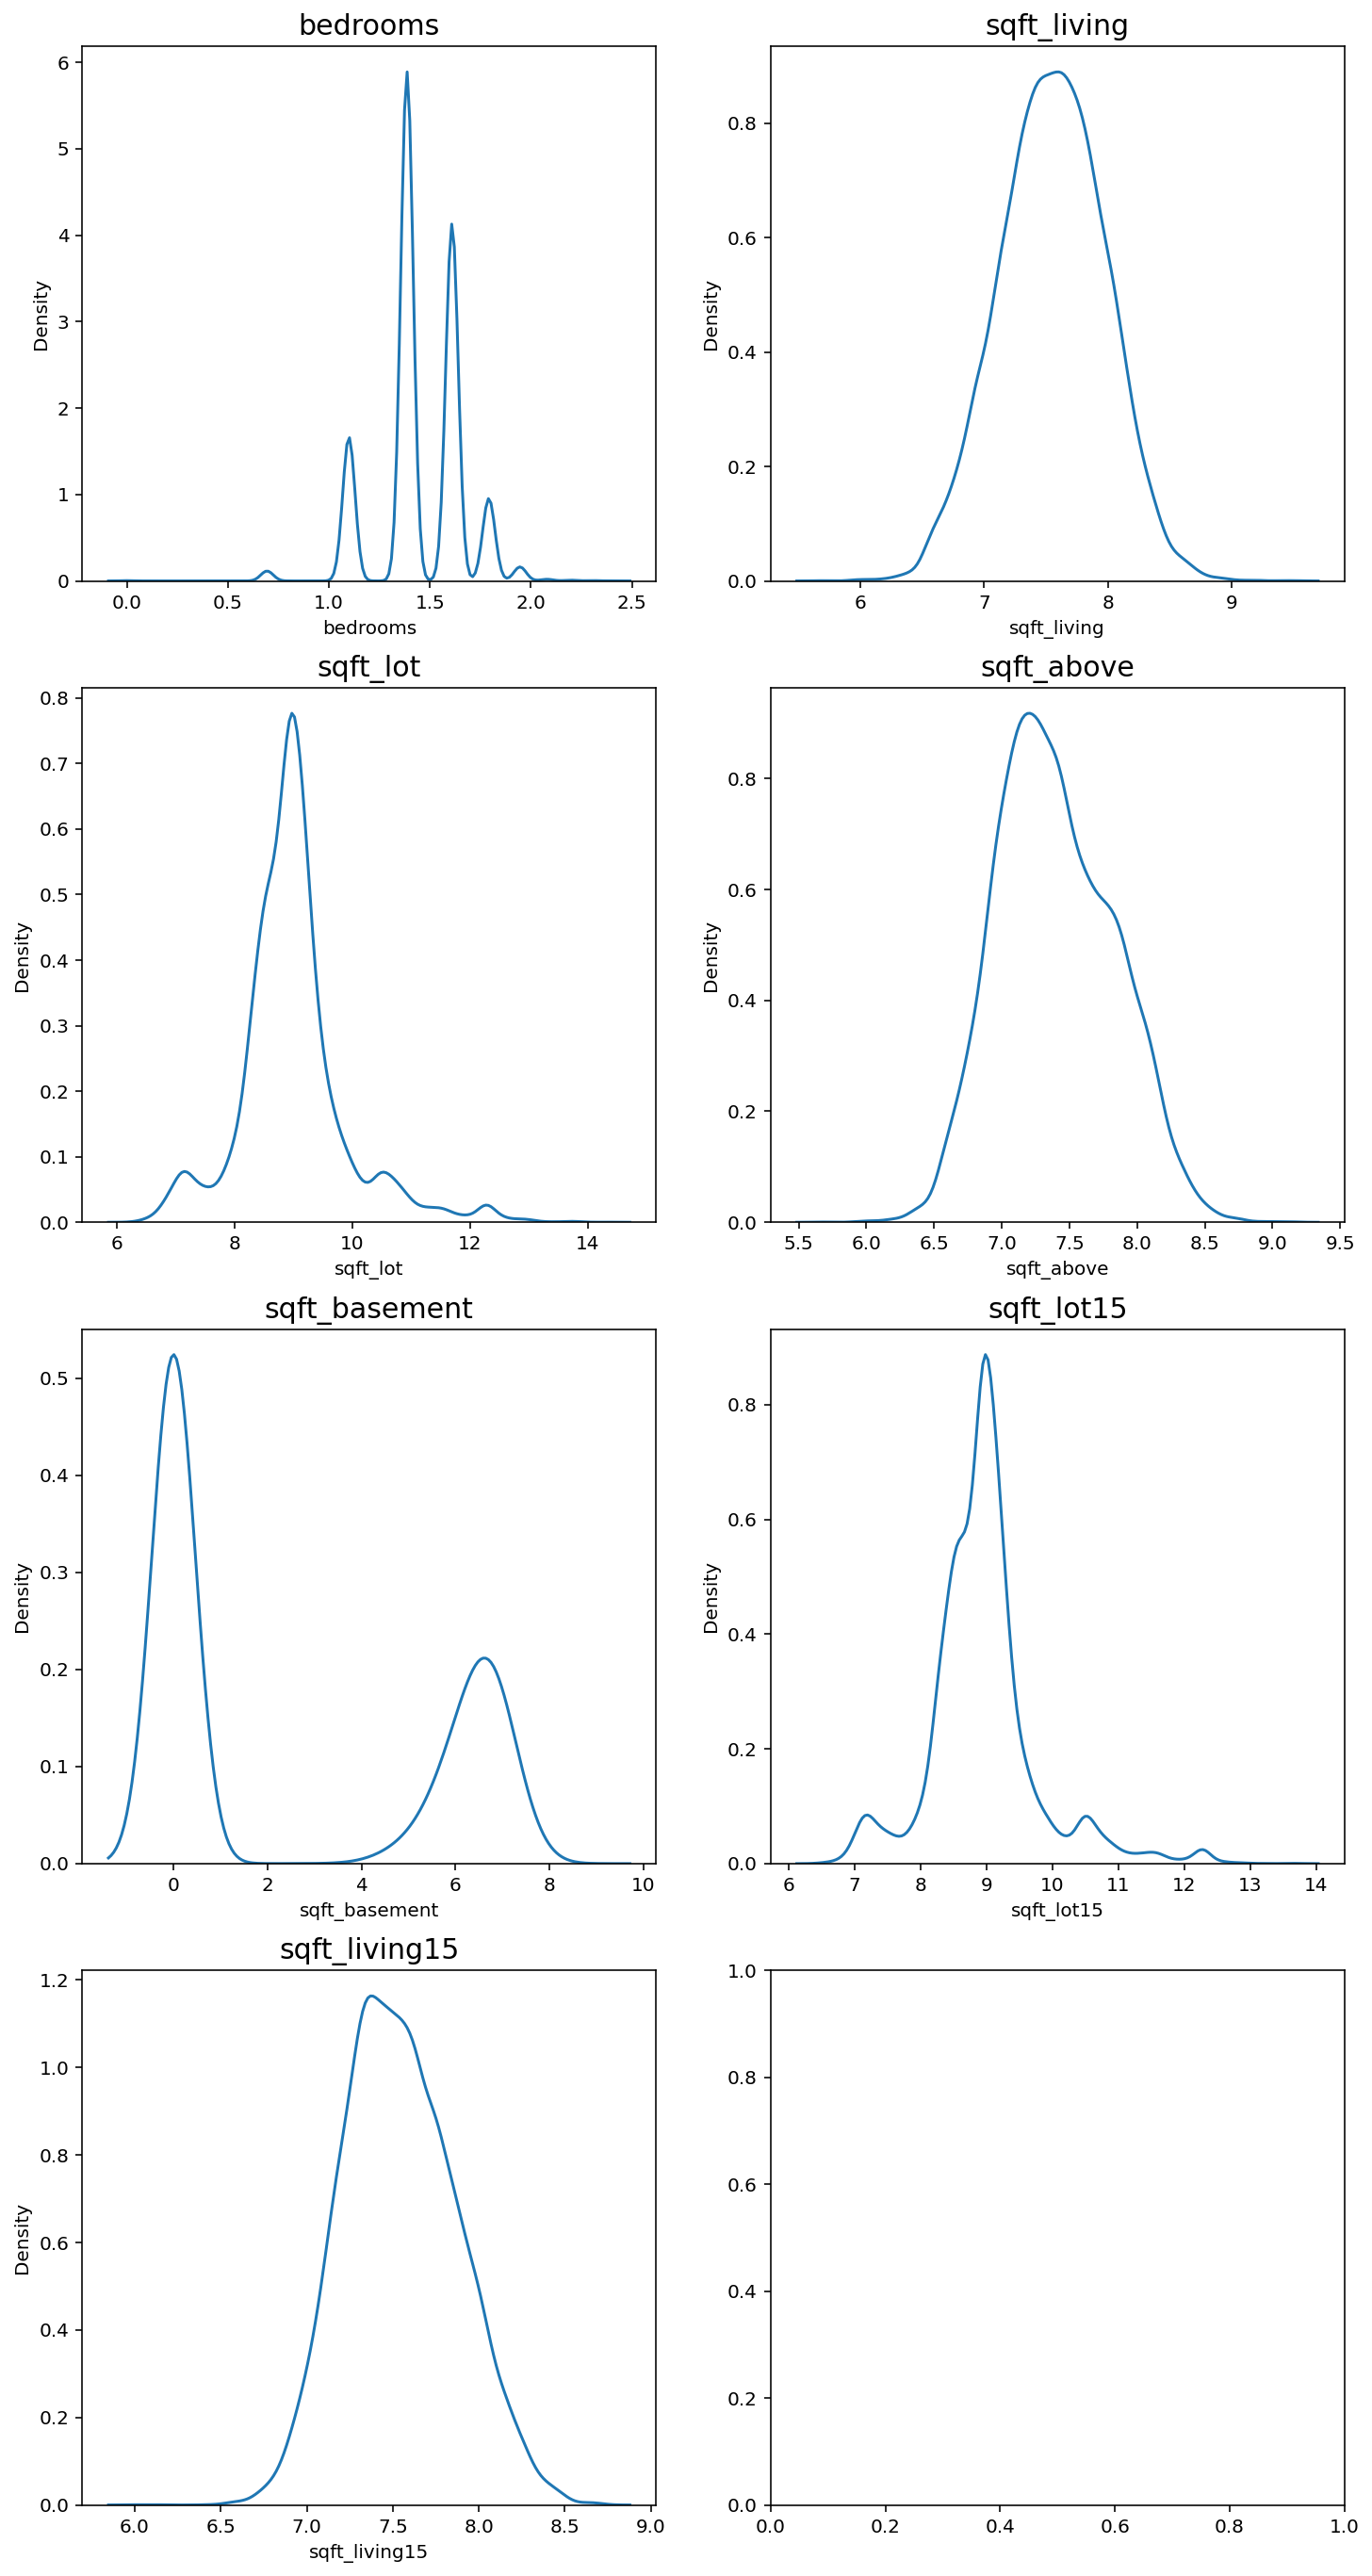

In [20]:

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)   
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break            
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        


price도 한쪽으로 치우쳐져있어 log로 정규화 하겠습니다.

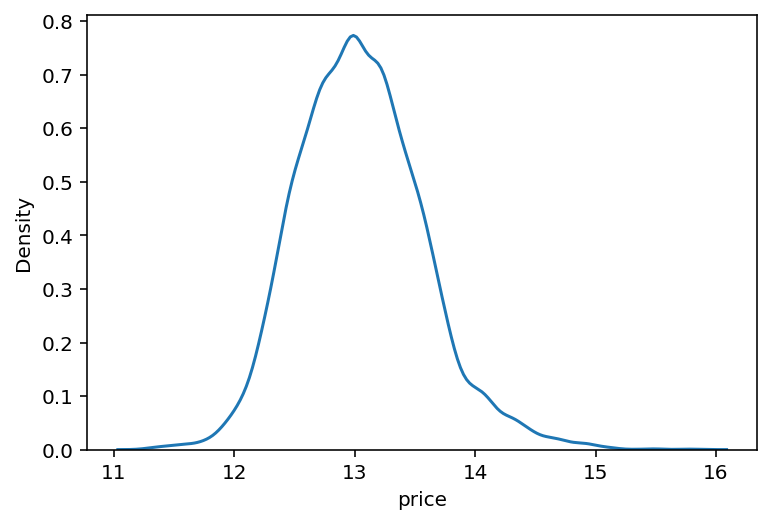

In [21]:
y = np.log1p(y)
train['price']=np.log1p(train['price'])

sns.kdeplot(y)
plt.show()

### 5-2 이상치 제거


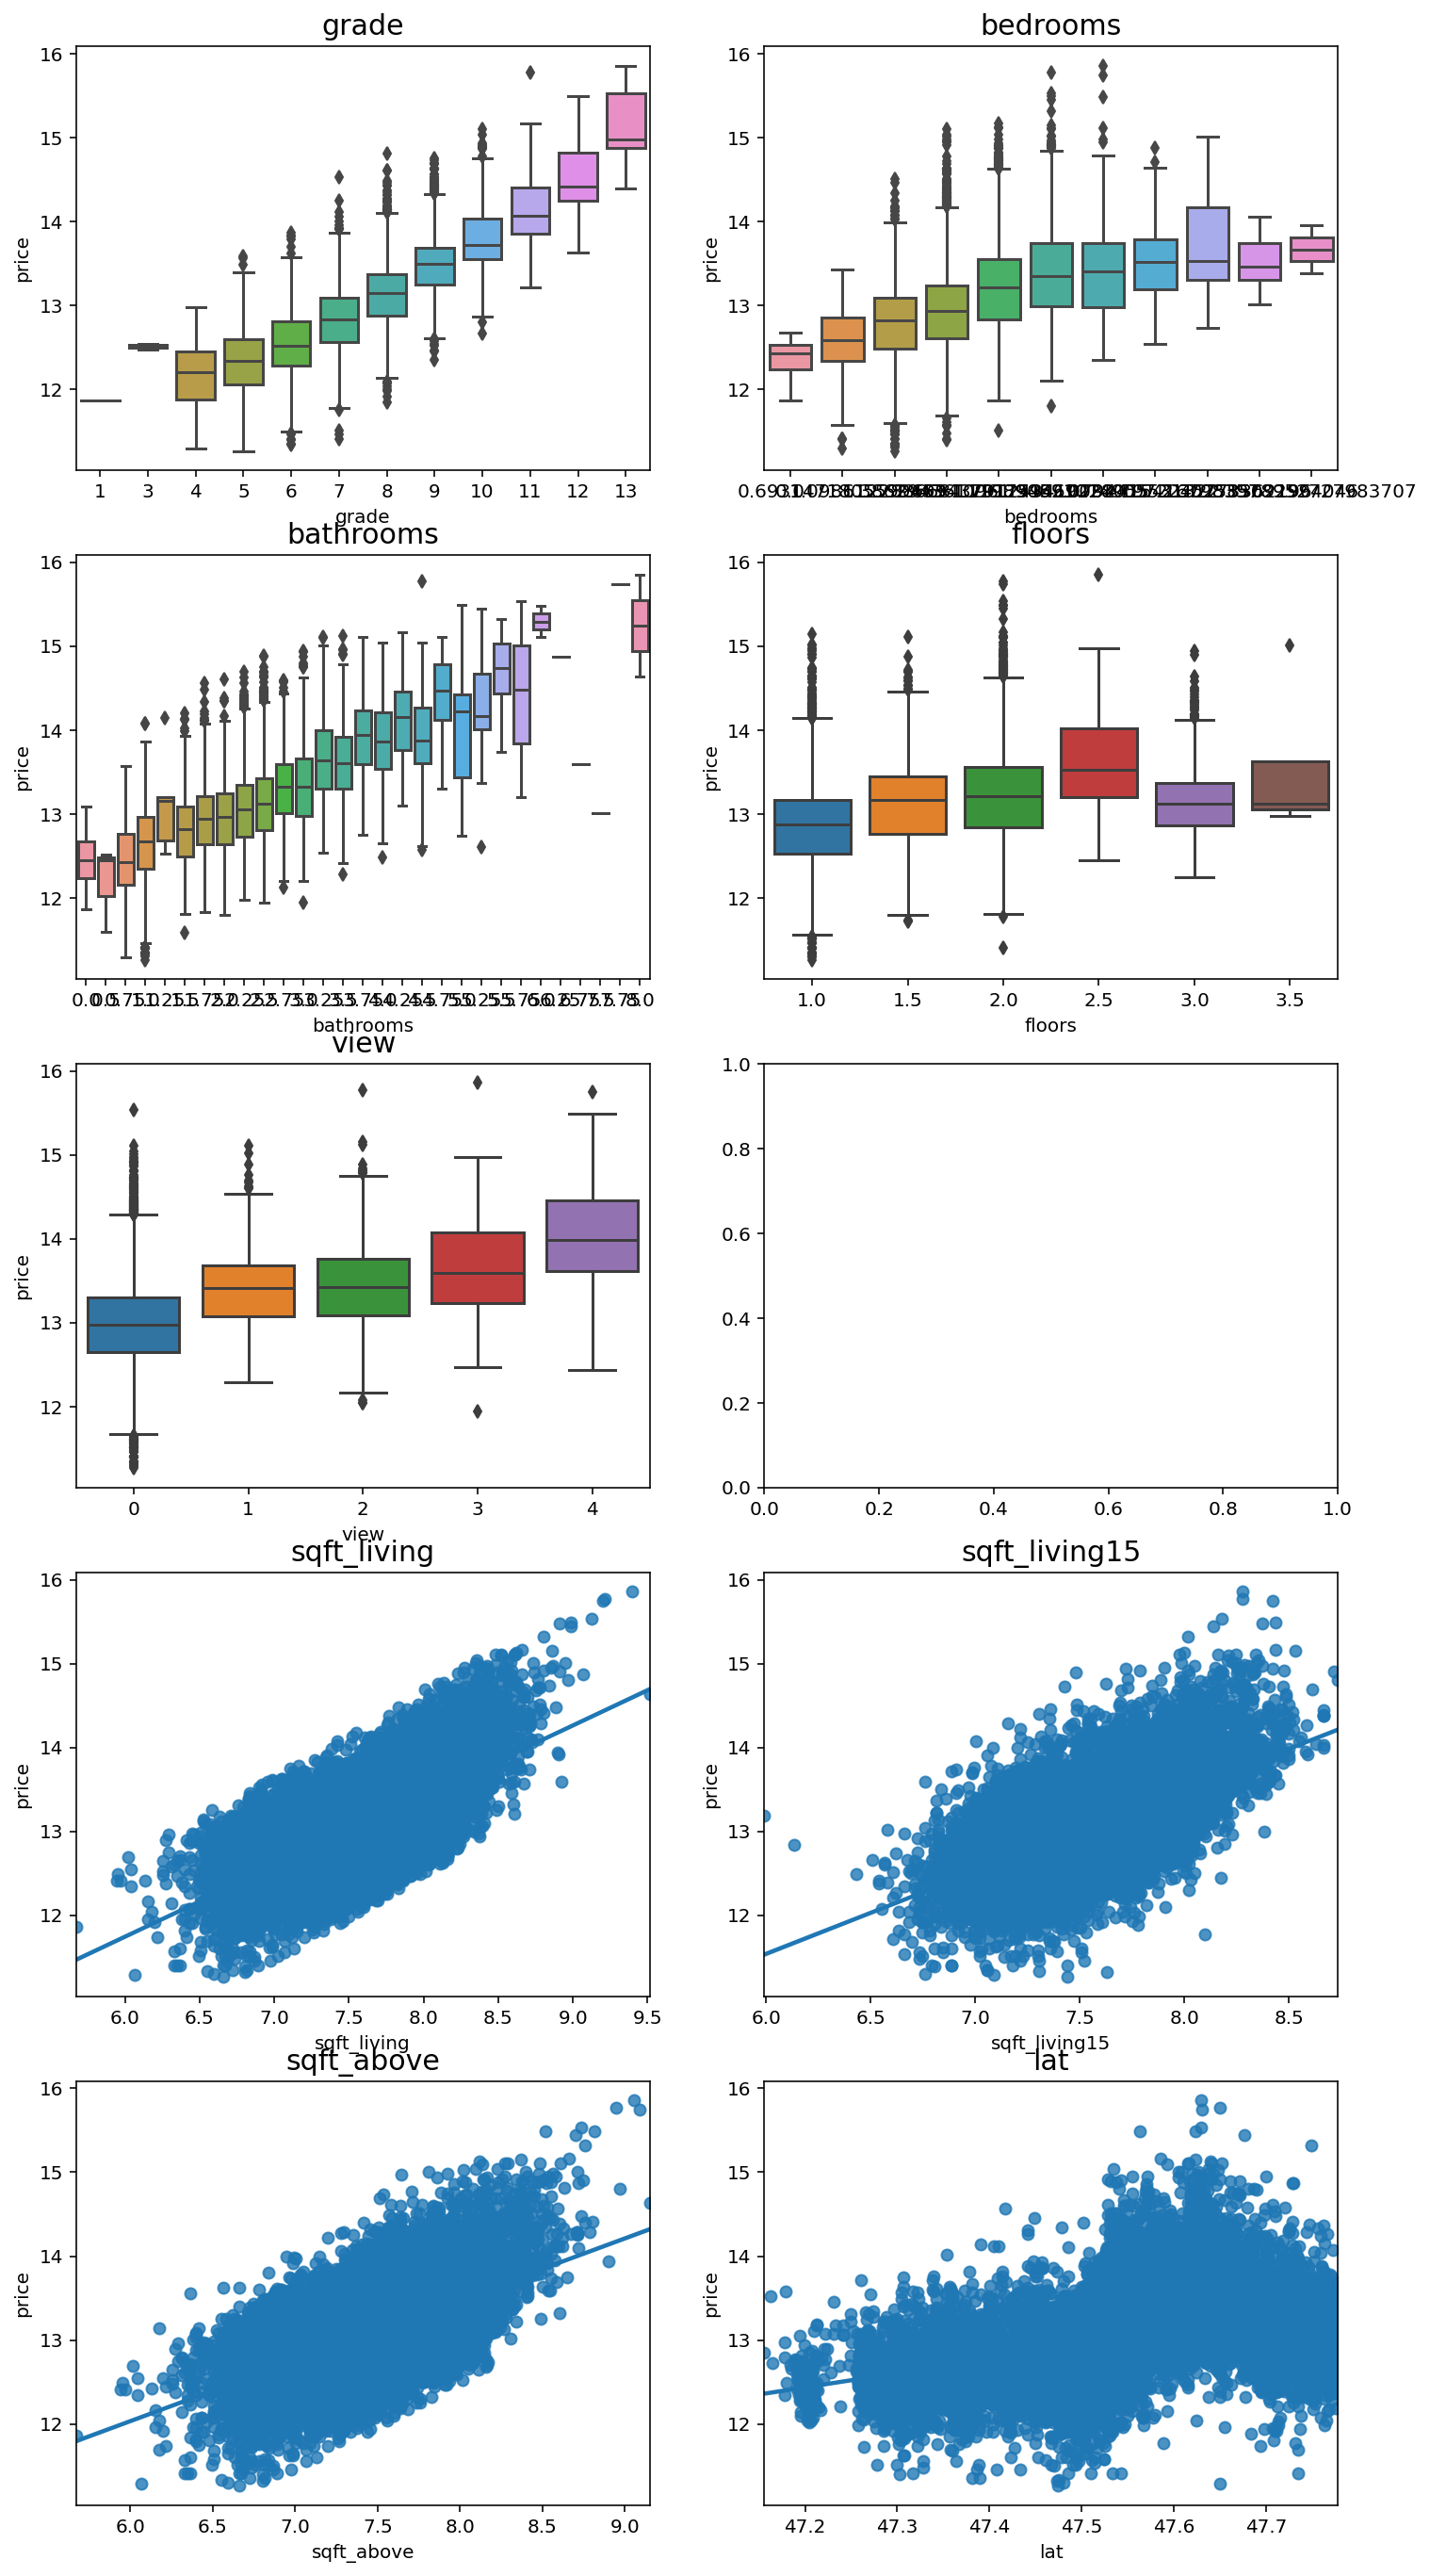

In [22]:
skew_columns_cart = ['grade','bedrooms','bathrooms', 'floors','view']
skew_columns_val = ['sqft_living','sqft_living15','sqft_above','lat','sqft_basement']
fig, ax = plt.subplots(5, 2, figsize=(12, 24))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.boxplot(x=skew_columns_cart[count], y="price", data=train,ax=ax[row][col])
        ax[row][col].set_title(skew_columns_cart[count], fontsize=15)
        count += 1
count=0        
for row in range(3,5):
    for col in range(2):
        if count == 6:
            break       
        sns.regplot(x=skew_columns_val[count], y="price", data=train,ax=ax[row][col])
        ax[row][col].set_title(skew_columns_val[count], fontsize=15)
        count += 1        

In [23]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,201502,12.476104,0.693147,0.75,6.255750,9.471319,1.0,0,0,5,3,6.255750,0.0,1920,0,98022,47.2082,-121.995,7.201171,9.411974
4123,201411,12.542548,0.693147,0.00,6.398595,10.106510,1.0,0,0,2,3,6.398595,0.0,1950,0,98045,47.5316,-121.749,6.898715,10.023490


In [24]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.77031,1.791759,4.5,9.214432,10.527445,2.0,1,2,3,11,8.946505,7.766841,1940,2001,98004,47.65,-122.214,8.276649,10.144471


In [25]:
train = train.loc[train.index !=2302]
train = train.loc[train.index !=2775]
train = train.loc[train.index !=4123]

In [26]:
train_log=train.drop('price',axis=1)
y=train['price']

* price와 상관관계가 높은 grade에서의 이상치를 판단하여 이상치를 제거했습니다.

## 5. 모델 적용 및 점수확인
1. 점수계산함수

In [27]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

2. 적용 모델 호출

In [28]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state, max_depth=90,max_features=3,min_samples_leaf=5, min_samples_split=8,n_estimators=100)
xgboost = XGBRegressor(random_state=random_state,learning_rate=0.1,max_depth=10,n_estimators=75)

lightgbm=LGBMRegressor(max_depth=8, n_estimators=75,learning_rate=0.05,num_leaves=1023,random_state=random_state,num_iterations=1000)
rdforest = RandomForestRegressor(random_state=random_state, n_estimators=200,max_depth=12,min_samples_leaf=3,min_samples_split=5)

models_all = [gboost, xgboost, lightgbm, rdforest]
models = [xgboost,lightgbm,gboost,rdforest]

In [29]:

print(get_scores(models, train_log, y))


                                    RMSE
RandomForestRegressor      130866.185061
GradientBoostingRegressor  117735.092926
XGBRegressor               113695.278550
LGBMRegressor              108163.115869


* score값이 좋아진것을 볼수 있었습니다.

In [30]:

models2 = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':rdforest, 'name':'rdforest'} ]

def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train_log.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train_log.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models2)


Model: GradientBoosting, CV score:0.8892
Model: XGBoost, CV score:0.9009
Model: LightGBM, CV score:0.9022
Model: rdforest, CV score:0.8810


In [31]:

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [34]:

y_pred = AveragingBlending(models2, train_log, y, test)

print(len(y_pred))
y_pred
sub_id = test['id']
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.to_csv('submission.csv', index=False)

print("finish")

finish


## 5. 하이퍼 파라미터 찾기(최적화)
1. GridSearch를 통해 찾기

In [318]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [319]:
param_grid = {
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]  
}
model = GradientBoostingRegressor(random_state=random_state)


In [320]:
print(my_GridSearch(model, train_log, y, param_grid, verbose=2, n_jobs=5))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 25.7min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 47.2min
[Parallel(n_jobs=5)]: Done 810 out of 810 | elapsed: 62.2min finished


     max_depth  max_features  min_samples_leaf  min_samples_split  \
99          90             3                 5                  8   
102         90             3                 5                 10   
45          80             3                 5                  8   
48          80             3                 5                 10   
103         90             3                 5                 10   
..         ...           ...               ...                ...   
108        100             2                 3                  8   
54          90             2                 3                  8   
0           80             2                 3                  8   
109        100             2                 3                  8   
110        100             2                 3                  8   

     n_estimators     score     RMSLE  
99            100 -0.030692  0.175191  
102           100 -0.030692  0.175191  
45            100 -0.030701  0.175218  
48         

In [321]:
param_grid = {
    'n_estimators': range(0,100,25),
    'max_depth': [6, 8, 10],
    'learning_rate':[0.01,0.05,0.1],
    'num_iterations':[500,1000]    
}
model = XGBRegressor(random_state=random_state,eta=0.1,max_depth=10, max_leaves=1023, booster='dart')

In [322]:
print(my_GridSearch(model, train_log, y, param_grid, verbose=2, n_jobs=5))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  41 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed: 33.8min finished


[06:39:20] WARNING: ../src/learner.cc:541: 
Parameters: { num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


    learning_rate  max_depth  n_estimators  num_iterations       score  \
71           0.10         10            75            1000   -0.027315   
70           0.10         10            75             500   -0.027315   
63           0.10          8            75            1000   -0.027626   
62           0.10          8            75             500   -0.027626   
55           0.10          6            75            1000   -0.029186   
..            ...        ...           ...             ...         ...   
40           0.05         10             0             500 -157.730404   
24           0.05          6             0             500 -157.730404   


In [334]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[3,5,7,10],
    'min_samples_split':[2,3,5,10]
}
model= RandomForestRegressor(random_state=random_state)

In [335]:
print(my_GridSearch(model, train_log, y, param_grid, verbose=2, n_jobs=5))

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  7.0min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 19.3min
[Parallel(n_jobs=5)]: Done 640 out of 640 | elapsed: 40.9min finished


     max_depth  min_samples_leaf  min_samples_split  n_estimators     score  \
101         12                 3                  5           200 -0.032966   
97          12                 3                  2           200 -0.032966   
99          12                 3                  3           200 -0.032966   
98          12                 3                  3           100 -0.033060   
100         12                 3                  5           100 -0.033060   
..         ...               ...                ...           ...       ...   
23           6                 7                 10           200 -0.050532   
29           6                10                  5           200 -0.050604   
25           6                10                  2           200 -0.050604   
31           6                10                 10           200 -0.050604   
27           6                10                  3           200 -0.050604   

        RMSLE  
101  0.181564  
97   0.181564  
99 

In [325]:
param_grid = {
    'n_estimators': range(0,100,25),
    'max_depth': [7,10],
    'learning_rate':[0.01,0.1],
    'num_iterations':[500,1000]
}
model = LGBMRegressor(random_state=random_state)

In [326]:
print(my_GridSearch(model, train_log, y, param_grid, verbose=2, n_jobs=5))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  5.4min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 13.7min
[Parallel(n_jobs=5)]: Done 1200 out of 1200 | elapsed: 17.1min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
     learning_rate  max_depth  n_estimators  num_iterations     score  \
143           0.05          8            75            1000 -0.025850   
141           0.05          8            50            1000 -0.025850   
139           0.05          8            25            1000 -0.025850   
137           0.05          8             0            1000 -0.025850   
133           0.05          7            50            1000 -0.025871   
..             ...        ...           ...             ...       ...   
1             0.01          1             0            1000 -0.055722   
6             0.01          1            75             500 -0.074576   
4             0.01          1            50             500 -0.074576   
2             0.01          1            25             500 -0.074576   
0             0.01          1             0             500 -0.0745

### 고찰
* 데이터 전처리를 시각화를 통해 이상치를 제거했고 그다음 grid 서치를 통해 하이퍼파라미터를 선택한 후 blending을 사용해 결과를 도출했습니다. 그러나 이상치제거와, grid 서치 과정이 잘되지 않았는지 최종결과는 110000점 이하를 받지 못했다.

* 시간이 부족해 못넘는 원인을 찾지는 못했으나 추측을해보면 제가 이상치라고 생각한 데이터가 중요한 데이터이기 때문에 결과에 안좋은 영향을 줄 수 있다고 생각하고 grid 서치할때 좀더 많은 범위로 서칭을 했으면 더 좋은 결과가 나왔을 것이라고 생각됩니다.

* 최종 결과는 114253.13282점이 나왔습니다. 목표하는 점수는 나오지 않았지만 시계열 데이터를 처음 다뤘던 경험이 너무 좋았습니다. 시각화, 데이터전처리 등을 실제 데이터를 기준으로 해봤다는 경험이 정말 많이 도움됐습니다. 감사합니다. 
